Episode 0, Total Reward: 19.0
Episode 10, Total Reward: 16.0
Episode 20, Total Reward: 14.0
Episode 30, Total Reward: 23.0
Episode 40, Total Reward: 18.0
Episode 50, Total Reward: 13.0
Episode 60, Total Reward: 35.0
Episode 70, Total Reward: 13.0
Episode 80, Total Reward: 47.0
Episode 90, Total Reward: 13.0
Episode 100, Total Reward: 15.0
Episode 110, Total Reward: 19.0
Episode 120, Total Reward: 19.0
Episode 130, Total Reward: 12.0
Episode 140, Total Reward: 12.0
Episode 150, Total Reward: 26.0
Episode 160, Total Reward: 10.0
Episode 170, Total Reward: 35.0
Episode 180, Total Reward: 47.0
Episode 190, Total Reward: 15.0
Episode 200, Total Reward: 22.0
Episode 210, Total Reward: 29.0
Episode 220, Total Reward: 33.0
Episode 230, Total Reward: 35.0
Episode 240, Total Reward: 176.0
Episode 250, Total Reward: 40.0
Episode 260, Total Reward: 56.0
Episode 270, Total Reward: 60.0
Episode 280, Total Reward: 84.0
Episode 290, Total Reward: 126.0
Episode 300, Total Reward: 132.0
Episode 310, Tot

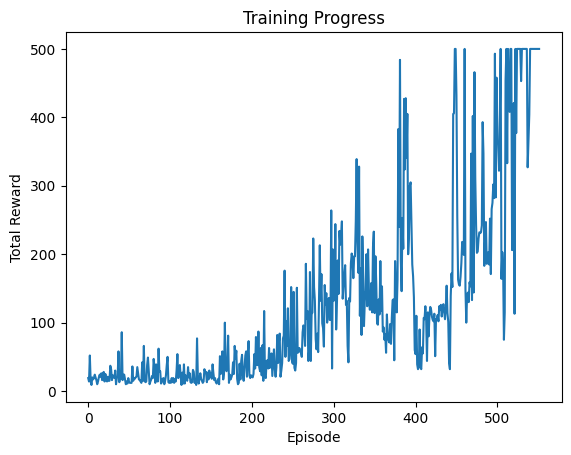

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_EPISODES = 3000
NUM_NEURONS = 64
LR_CRITIC = 0.0005
LR_ACTOR = 0.0001
GAMMA = 0.99
EARLY_STOP_THRESHOLD = 480
EARLY_STOP_EPISODES = 30


class PolicyNet(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, num_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Agent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
    
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.actor(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item()
    
    def update(self, state, action, next_state, reward, done):
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.int64)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)

        value = self.critic(state).squeeze()
        target_value = reward + self.critic(next_state).squeeze() * GAMMA * (1 - done)
        advantage = target_value - value

        pi = self.actor(state)
        log_prob = Categorical(pi).log_prob(action)

        critic_loss = nn.MSELoss()(value, target_value.detach())
        
        actor_loss = -log_prob * advantage.detach()
        
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()


def train_a2c(env_name='CartPole-v1', num_episodes=MAX_EPISODES):
    env = gym.make(env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n
    agent = Agent(num_inputs, num_actions)
    reward_history = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        early_stop = False
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.update(state, action, next_state, reward, done)
            state = next_state
            total_reward += reward

        reward_history.append(total_reward)
        
        if len(reward_history) >= 50 and np.mean(reward_history[-EARLY_STOP_EPISODES:]) > EARLY_STOP_THRESHOLD:
            print(f"Early stopping at episode {episode}, average reward: {np.mean(reward_history[-EARLY_STOP_EPISODES:])}")
            early_stop = True
            break
        
        if early_stop:
            break
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()


    return agent

if __name__ == "__main__":
    trained_agent = train_a2c()


GIF saved at cartpole_actor_critic.gif


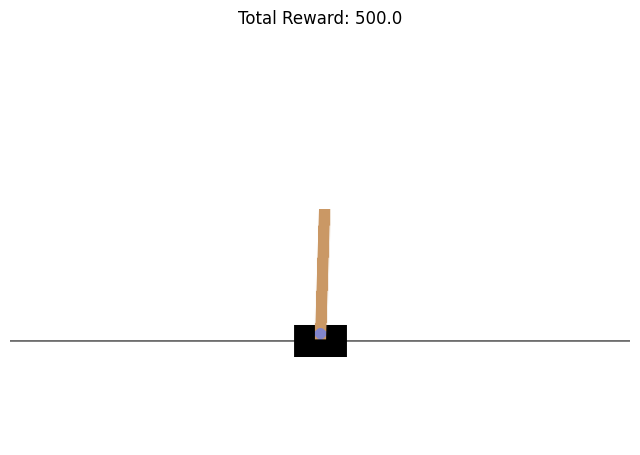

500.0

In [2]:
import gymnasium as gym
import torch
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def test_and_generate_gif(agent, env_name='CartPole-v1', gif_path='cartpole_actor_critic.gif'):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    frames = []
    total_reward = 0
    done = False
    
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        probs = agent.actor(state_tensor)
        action = torch.argmax(probs).item()
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
        frames.append(Image.fromarray(env.render()))
    
    env.close()
    
    # Save GIF
    frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=50, loop=0)
    print(f"GIF saved at {gif_path}")
    
    # Display GIF
    plt.figure(figsize=(8, 6))
    plt.imshow(np.array(frames[0]))
    plt.axis('off')
    plt.title(f'Total Reward: {total_reward}')
    plt.show()
    
    return total_reward

test_and_generate_gif(trained_agent)
